***Kernel Density Estimator***

In [1]:
import numpy as np

In [2]:
bq_data = np.loadtxt('./data/BQmat_orig.txt', delimiter=',')

#### I. 3D surface plot ####

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [6]:
X = np.linspace(18, 95, num = 78)
Y = np.linspace(1, 7, num = 7)

X_i, Y_i = np.mgrid[18:95:78j, 1:7:7j]

In [7]:
def plot_3D_surface(dist):

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X_i, Y_i, dist, rstride=5)
    ax.set_xlabel("ages")
    ax.set_ylabel("income groups")
    ax.set_zlabel("Percent of income")
    
    return

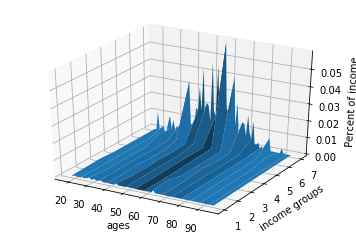

In [8]:
plot_3D_surface(bq_data)

#### II. bivariate kernel density estimator ####

In [1]:
import pandas as pd
from scipy.stats import gaussian_kde
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KernelDensity

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [70]:
def get_frequency(times):
    
    data_list = []
    bq_data_new = bq_data * times
    for i in range(len(X)):
        x = X[i]
        for j in range(len(Y)):
            y = Y[j]
            num = bq_data_new[i,j]
            data = (x, y)
            for time in range(int(round(num))):
                data_list.append(data)
                data_df = pd.DataFrame(data_list)
    
    return data_df

In [75]:
def get_estimate(times):
    
    data_df = get_frequency(times)
    bandwidths = 10 ** np.linspace(-1, 1, 100)
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                        {'bandwidth': bandwidths},
                        cv=LeaveOneOut(data_df.shape[0]))
    grid.fit(data_df)
    bandwidth = grid.best_params_['bandwidth']
    kernel = gaussian_kde(data_df.T, bw_method=bandwidth)
    coords = np.vstack([item.ravel() for item in [X_i, Y_i]])

    Z = np.reshape(kernel(coords), X_i.shape)
    Z_scaled = Z / float(np.sum(Z))
    
    return Z_scaled, bandwidth

In [76]:
Z_scaled, bandwidth = get_estimate(1000)

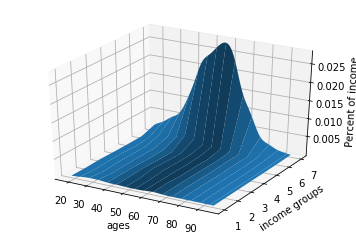

In [77]:
plot_3D_surface(Z_scaled)

In [79]:
print('The λ we choose is', bandwidth, 'which is got from leave-one-out cross-validation based on the sample size')

The λ we choose is 0.2535364493970112 which is got from leave-one-out cross-validation based on the sample size


In [83]:
print('The estimate of bequest recipients who are age 61 in the 6th lifetime income category is', Z_scaled[43, 5])

The estimate of bequest recipients who are age 61 in the 6th lifetime income category is 0.0009233266576317442


***Interaction Term***

In [2]:
BIDEN = pd.read_csv('./data/biden.csv')
BIDEN.head()

,biden,female,age,educ,dem,rep
0,90.0,0,19.0,12.0,1.0,0.0
1,70.0,1,51.0,14.0,1.0,0.0
2,60.0,0,27.0,14.0,0.0,0.0
3,50.0,1,43.0,14.0,1.0,0.0
4,60.0,1,38.0,14.0,0.0,1.0


In [10]:
BIDEN['constant'] = 1
Y = BIDEN['biden']
X1 = BIDEN['age']
X2 = BIDEN['educ']
CONSTANT = BIDEN['constant']
X = pd.concat([CONSTANT, X1, X2, X1 * X2], axis = 1)

In [11]:
import statsmodels.api as sm
reg1 = sm.OLS(endog=Y, exog=X, missing='drop')

In [12]:
results = reg1.fit()

In [13]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  biden   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     10.13
Date:                Mon, 30 Apr 2018   Prob (F-statistic):           1.29e-06
Time:                        10:40:05   Log-Likelihood:                -8333.3
No. Observations:                1826   AIC:                         1.667e+04
Df Residuals:                    1822   BIC:                         1.670e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      37.5491      9.491      3.956      0.0

#### I. Marginal effect of age ####

From the summary table we can see the marginal effect of age on thermometer rating is 0.6674 - 0.0477*X2* <br />
And the F-test shows it's significant. 

In [19]:
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

In [30]:
reg_11 = ols('biden ~ age:educ', data = BIDEN).fit()
reg_12 = ols('biden ~ age + age:educ', data = BIDEN).fit()

In [34]:
anovaResults = anova_lm(reg_11, reg_12)
anovaResults

C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1824.0,999961.929985,0.0,NaN,NaN,NaN
1,1823.0,987142.686399,1.0,12819.243585,23.673863,0.000001


#### II. Marginal effect of education ####

From the summary table we can see the marginal effect of age on thermometer rating is 1.7123 - 0.0477*X1* <br />
And the F-test shows it's significant.

In [33]:
reg_21 = ols('biden ~ age:educ', data = BIDEN).fit()
reg_22 = ols('biden ~ educ + age:educ', data = BIDEN).fit()
anovaResults = anova_lm(reg_21, reg_22)
anovaResults

C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1824.0,999961.929985,0.0,NaN,NaN,NaN
1,1823.0,992421.650428,1.0,7540.279556,13.850897,0.000204


<IPython.core.display.Javascript object>


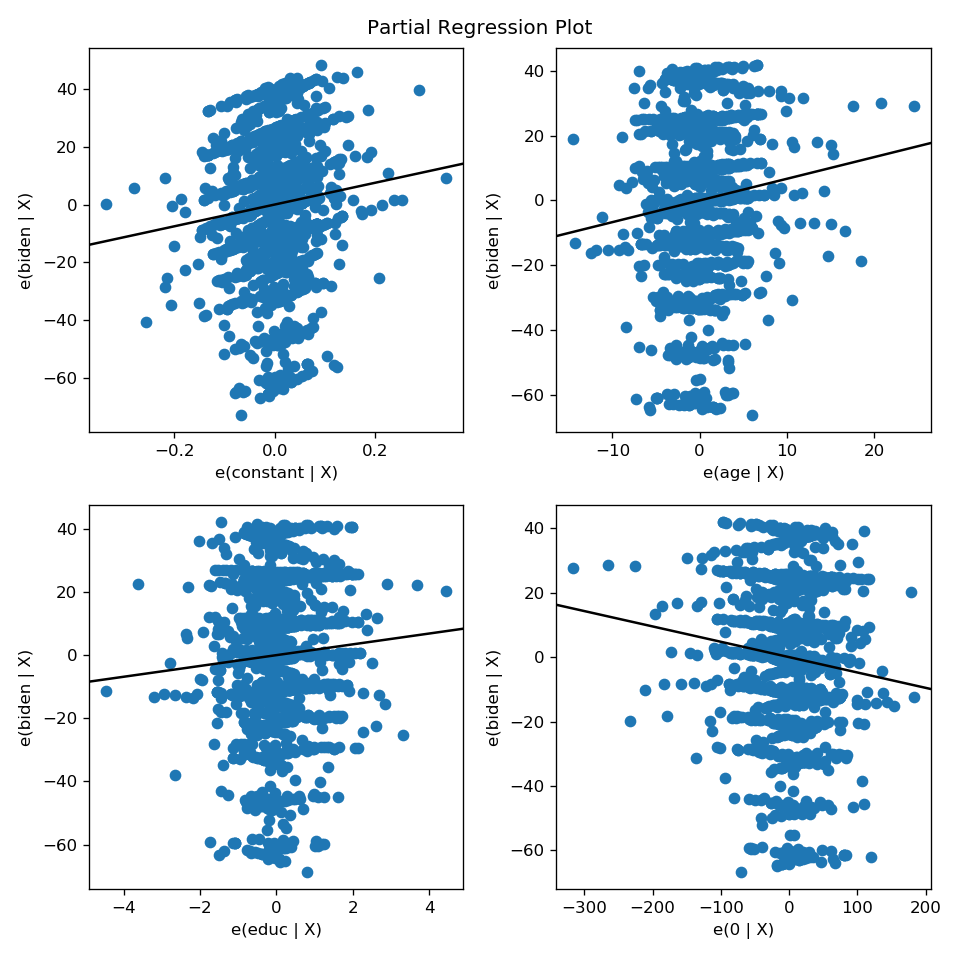

In [15]:
fig = plt.figure(figsize=(8,8))
fig = sm.graphics.plot_partregress_grid(results, fig=fig)

From the above plots, we can se the direction of impact of both education and age are both positive.